# Neuroimaging data in python

In this tutorial we will learn the basics of querying BIDS-formatted datasets and how to load and plot neuroimaging data.

## Navigating BIDS-formatted Neuroimaging Data

The [Brain Imaging Dataset Specification](http://bids.neuroimaging.io/) provides a standardized file organization and naming scheme. One great benefit of a standard specification for datasets is that tools can be developed around this specification making the generally useful for any BIDS-formatted dataset. pybids is one such tool that has been developed to query and navigate a neuroimaging dataset.

In [65]:
from bids import BIDSLayout, BIDSValidator
import os

# update this path to your local copy of the localizer data downloaded in the initial preparations notebook
data_dir = '/Users/michael/Dropbox/work/data/dartbrains/data/localizer'
layout = BIDSLayout(data_dir,derivatives=True)
layout

/usr/local/Caskroom/miniconda/base/envs/pymri/lib/python3.10/site-packages/bids/layout/validation.py:156: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


BIDS Layout: ...data/dartbrains/data/localizer | Subjects: 5 | Sessions: 0 | Runs: 0

When we initialize a BIDSLayout, all of the files and metadata found under the specified root folder are indexed. This can take a few seconds (or, for very large datasets, a minute or two). Once initialization is complete, we can start querying the BIDSLayout in various ways. The main query method is .get(). If we call .get() with no additional arguments, we get back a list of all the BIDS files in our dataset.

Let’s return the first 10 files

In [66]:
layout.get()[:10]

[<BIDSJSONFile filename='/Users/michael/Dropbox/work/data/dartbrains/data/localizer/dataset_description.json'>,
 <BIDSFile filename='/Users/michael/Dropbox/work/data/dartbrains/data/localizer/derivatives/.DS_Store'>,
 <BIDSFile filename='/Users/michael/Dropbox/work/data/dartbrains/data/localizer/derivatives/fmriprep/.DS_Store'>,
 <BIDSJSONFile filename='/Users/michael/Dropbox/work/data/dartbrains/data/localizer/derivatives/fmriprep/dataset_description.json'>,
 <BIDSFile filename='/Users/michael/Dropbox/work/data/dartbrains/data/localizer/derivatives/fmriprep/logs/CITATION.bib'>,
 <BIDSFile filename='/Users/michael/Dropbox/work/data/dartbrains/data/localizer/derivatives/fmriprep/logs/CITATION.html'>,
 <BIDSFile filename='/Users/michael/Dropbox/work/data/dartbrains/data/localizer/derivatives/fmriprep/logs/CITATION.md'>,
 <BIDSFile filename='/Users/michael/Dropbox/work/data/dartbrains/data/localizer/derivatives/fmriprep/logs/CITATION.tex'>,
 <BIDSFile filename='/Users/michael/Dropbox/work

As you can see, just a generic .get() call gives us all of the files. We will definitely want to be a bit more specific. We can specify the type of data we would like to query. For example, suppose we want to return the first 5 subject ids.

In [67]:
layout.get(target='subject', return_type='id', scope='derivatives')[:5]

['S02', 'S04', 'S03', 'S05', 'S01']

Or perhaps, we would like to get the file names for the raw bold functional nifti images for the first 5 subjects. We can filter files in the raw or derivatives directories using the `scope` keyword.

In [68]:
layout.get(task='localizer', suffix='bold', scope='raw')[:5]

[<BIDSImageFile filename='/Users/michael/Dropbox/work/data/dartbrains/data/localizer/sub-S01/func/sub-S01_task-localizer_bold.nii.gz'>,
 <BIDSImageFile filename='/Users/michael/Dropbox/work/data/dartbrains/data/localizer/sub-S02/func/sub-S02_task-localizer_bold.nii.gz'>,
 <BIDSImageFile filename='/Users/michael/Dropbox/work/data/dartbrains/data/localizer/sub-S03/func/sub-S03_task-localizer_bold.nii.gz'>,
 <BIDSImageFile filename='/Users/michael/Dropbox/work/data/dartbrains/data/localizer/sub-S04/func/sub-S04_task-localizer_bold.nii.gz'>,
 <BIDSImageFile filename='/Users/michael/Dropbox/work/data/dartbrains/data/localizer/sub-S05/func/sub-S05_task-localizer_bold.nii.gz'>]

The BIDS naming scheme includes many fields (e.g., sub, task, space, desc) and all of these can be used to query a dataset with .get():

In [69]:
layout.get(subject='S01',scope='raw',task='localizer')

[<BIDSImageFile filename='/Users/michael/Dropbox/work/data/dartbrains/data/localizer/sub-S01/func/sub-S01_task-localizer_bold.nii.gz'>,
 <BIDSDataFile filename='/Users/michael/Dropbox/work/data/dartbrains/data/localizer/sub-S01/func/sub-S01_task-localizer_events.tsv'>]

.get() returns BIDSImageFile entities which can contain different attributes:

In [70]:
f = layout.get(subject='S01',scope='derivatives',task='localizer',extension='.nii.gz')[0]
print(f'.filename: {f.filename}')
print(f'.path: {f.path}')
print(f'.dirname: {f.dirname}')

.filename: sub-S01_task-localizer_space-MNI152NLin2009cAsym_boldref.nii.gz
.path: /Users/michael/Dropbox/work/data/dartbrains/data/localizer/derivatives/fmriprep/sub-S01/func/sub-S01_task-localizer_space-MNI152NLin2009cAsym_boldref.nii.gz
.dirname: /Users/michael/Dropbox/work/data/dartbrains/data/localizer/derivatives/fmriprep/sub-S01/func


You can further specify what to return in a .get() call with `return_type`. For example, to grab just the file path, set `return_type` to 'file':

In [71]:
layout.get(subject='S01',scope='derivatives',task='localizer',desc='preproc',extension='.nii.gz',return_type='file')

['/Users/michael/Dropbox/work/data/dartbrains/data/localizer/derivatives/fmriprep/sub-S01/func/sub-S01_task-localizer_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']

## Loading data with nltools

The nltools packages provides easy to use methods for loading, plotting, and manipulating neuroimaging data. It uses many functions from nibabel and nilearn, two big python libraries in the neuroimaging world. nltools builds on these libraries to make life a little easier. It includes a `Brain_Data()` class that brings the best of pandas dataframes to neuroimaging data. `Brain_Data()` stores imaging data in `.data` as a features (voxels) x observations (images) matrix. A space flattener from nilearn is stored in `.nifti_masker`. And, a brain mask is stored in `.mask`. 

Let's see it action:

In [73]:
from nltools.data import Brain_Data
import matplotlib.pylab as plt
from nilearn.plotting import plot_glass_brain

bold_file = layout.get(subject='S01',scope='derivatives',suffix='bold',
                       extension='.nii.gz',return_type='file')[0]
bold = Brain_Data(bold_file)
bold

nltools.data.brain_data.Brain_Data(data=(128, 238955), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz)

`Brain_Data` puts all of the data in the `.data` attribute, which itself is a simple numpy array.

In [54]:
bold.data

array([[1244.4613 ,  766.18555,  425.79276, ..., 3931.623  , 3861.9114 ,
        2047.7985 ],
       [1291.1414 ,  800.7655 ,  442.84958, ..., 3894.9956 , 3819.5999 ,
        2051.7278 ],
       [1357.4722 ,  784.5982 ,  390.91232, ..., 3924.3596 , 3826.7715 ,
        1955.2667 ],
       ...,
       [1141.9368 ,  677.3974 ,  440.06454, ..., 3825.6895 , 3778.5552 ,
        2080.5732 ],
       [1116.4692 ,  618.9414 ,  383.482  , ..., 3873.3218 , 3683.8108 ,
        1970.625  ],
       [1179.6118 ,  655.6012 ,  392.208  , ..., 3889.399  , 3618.4558 ,
        2031.5696 ]], dtype=float32)

That means you can perform simple maths on the data with standard functions:

In [55]:
bold.mean()

nltools.data.brain_data.Brain_Data(data=(238955,), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz)

Overall mean across all voxels for each time point!

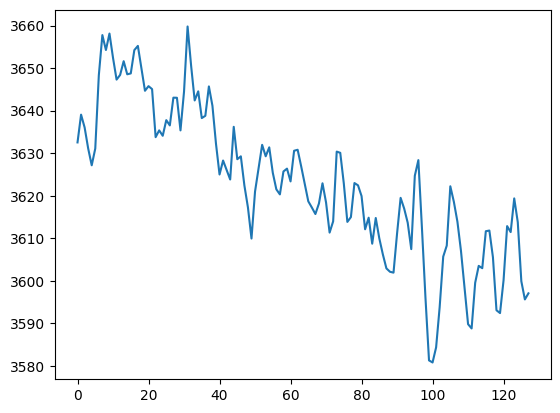

In [57]:
plt.plot(bold.mean(axis=1))

### Plotting

`Brain_Data` includes several methods for plotting data. 

A quick plot provides a montage of axial slices:

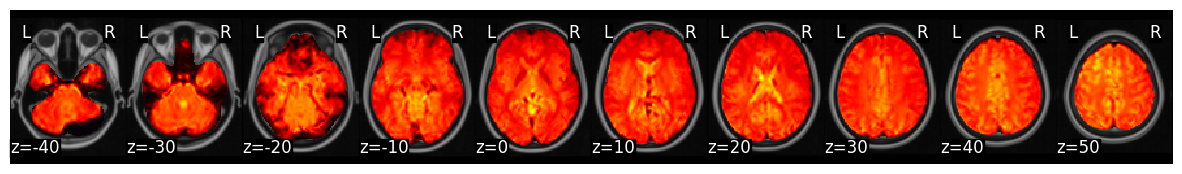

In [58]:
bold.mean().plot()

One thing to note about these plotting methods is that by default MNI space is assumed for all plots. This can be changed by setting the `anatomical` parameter in plot calls to point to a subject-specific or template-specific file. 

There is an interactive plot:

In [60]:
bold.mean().iplot()

interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

`Brain_Data` instances can also be converted to nibabel instances and plotted using any nilearn plot methods like glass brain:

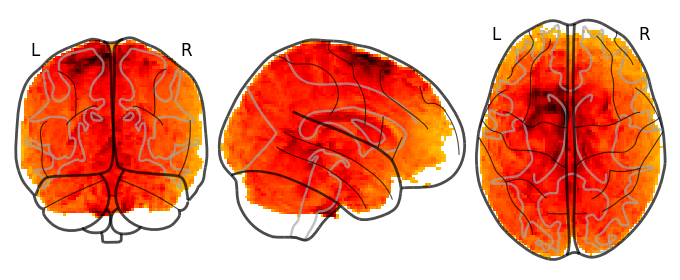

In [64]:
plot_glass_brain(bold.mean().to_nifti())